In [1]:
import optuna
from optuna.samplers import TPESampler
import pandas as pd
import numpy as np
import random
from pytorch_tabnet.tab_model import TabNetRegressor
from sklearn.preprocessing import StandardScaler
from pytorch_tabnet.augmentations import RegressionSMOTE
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
# Fix random seed
seed = 42
np.random.seed(seed)
random.seed(seed)
sampler = TPESampler(seed=seed)

# Pre-processing input data

In [3]:
def bits_to_MiB(row):
	# verify if has string ' MiB'
	if 'MiB' in str(row):
		row = row.replace(' MiB', '')
		row = float(row)
	else:
		row = float(row) / np.power(2, 20)
	return row


def MHz_to_GHz(row):
	# verify if has string ' GHz'
	if 'GHz' in str(row):
		row = row.replace(' GHz', '')
		# convert to float
		row = float(row)
	else:
		row = row.replace(' MHz', '')
		row = float(row) / 1000
	return row

In [4]:
results_df = pd.read_csv('../results_new/execution_time.csv')
results_savio_df = pd.read_csv('../results_savio_new/execution_time.csv')
results_df = pd.concat([results_df, results_savio_df], ignore_index=True)
# preprocessing
results_df['total_cpu_usage'] = results_df['total_cpu_usage'].str.replace('%', '').astype(float) / 100
results_df['max_ram_usage'] = results_df['max_ram_usage'] / 1024
results_df['l2_cache_size'] = results_df['l2_cache_size'].apply(bits_to_MiB)
results_df['l3_cache_size'] = results_df['l3_cache_size'].apply(bits_to_MiB)
results_df['ghz_actual_friendly'] = results_df['hz_actual_friendly'].apply(MHz_to_GHz)
results_df['ghz_advertised_friendly'] = results_df['hz_advertised_friendly'].str.replace('GHz', '').astype(float)
results_df = results_df.drop(columns=['hz_actual_friendly', 'hz_advertised_friendly', 'arch', 'vendor_id_raw'])

In [5]:
# Make the target dataset
target_df = results_df[['total_time', 'brand_raw', 'count', 'l2_cache_size', 'l3_cache_size', 'l2_cache_line_size', 'l2_cache_associativity', 'ghz_advertised_friendly', 'benchmark']].copy()
# Rename columns to *_target
target_df = target_df.rename(columns={
    'total_time': 'total_time_target',
    'brand_raw': 'brand_raw_target',
    'count': 'count_target',
    'l2_cache_size': 'l2_cache_size_target',
    'l3_cache_size': 'l3_cache_size_target',
    'l2_cache_line_size': 'l2_cache_line_size_target',
    'l2_cache_associativity': 'l2_cache_associativity_target',
    'ghz_advertised_friendly': 'ghz_advertised_friendly_target',
})

dataset_df = pd.merge(results_df, target_df, how='inner', on='benchmark')
dataset_df = dataset_df[dataset_df['brand_raw'] != dataset_df['brand_raw_target']]
dataset_df.head(2)

,total_time,total_cpu_usage,max_ram_usage,brand_raw,count,l2_cache_size,l3_cache_size,l2_cache_line_size,l2_cache_associativity,benchmark,ghz_actual_friendly,ghz_advertised_friendly,total_time_target,brand_raw_target,count_target,l2_cache_size_target,l3_cache_size_target,l2_cache_line_size_target,l2_cache_associativity_target,ghz_advertised_friendly_target
5,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,45.91,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496
6,13.47,0.99,1436.714844,Intel(R) Core(TM) i5-10400 CPU @ 2.90GHz,12,1.5,12.0,256,6,KNP,4.1729,2.9,25.77,13th Gen Intel(R) Core(TM) i5-1335U,12,7.5,12.0,1280,7,2.496


In [6]:
# remove one computer for testing
g_train = dataset_df[(dataset_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (dataset_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
g_test = dataset_df[dataset_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [7]:
mm_df = dataset_df[dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
mm_train = mm_df[(mm_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (mm_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
mm_test = mm_df[mm_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [8]:
st_df = dataset_df[~dataset_df['benchmark'].isin(['MATRIX_MULT', 'MATRIX_MULT2', 'MATRIX_MULT3'])]
# remove one computer for testing
st_train = st_df[(st_df['brand_raw'] != '13th Gen Intel(R) Core(TM) i5-1335U') & (st_df['brand_raw_target'] != '13th Gen Intel(R) Core(TM) i5-1335U')]
st_test = st_df[st_df['brand_raw_target'] == '13th Gen Intel(R) Core(TM) i5-1335U']

In [9]:
# load test dataset
g_test = pd.read_csv('csv/g_test.csv')
st_test = pd.read_csv('csv/st_test.csv')
mm_test = pd.read_csv('csv/mm_test.csv')

In [10]:
target = 'total_time_target'
features = mm_test.columns.copy().drop(target).drop(['benchmark','brand_raw', 'brand_raw_target'])
features_st = features.copy().drop(['count', 'count_target'])

In [11]:
# general data
## split data
X_g_train = g_train[features]
y_g_train = g_train[target]
#X_g_train, X_g_val, y_g_train, y_g_val = train_test_split(X_g_train, y_g_train, test_size=0.4, random_state=seed)

## test
X_g_test = g_test[features]
y_g_test = g_test[target]

## normalize data
scaler_g = StandardScaler()
X_g_train = scaler_g.fit_transform(X_g_train)
#X_g_val = scaler_g.fit_transform(X_g_val)
X_g_test = scaler_g.transform(X_g_test)

In [12]:
# single thread data
## split data
X_st_train = st_train[features_st]
y_st_train = st_train[target]
#X_st_train, X_st_val, y_st_train, y_st_val = train_test_split(X_st_train, y_st_train, test_size=0.4, random_state=seed)

## test
X_st_test = st_test[features_st]
y_st_test = st_test[target]

## normalize data
scaler_st = StandardScaler()
X_st_train = scaler_st.fit_transform(X_st_train)
#X_st_val = scaler_st.fit_transform(X_st_val)
X_st_test = scaler_st.transform(X_st_test)

In [13]:
# multi thread data
## split data
X_mm_train = mm_train[features]
y_mm_train = mm_train[target]
#X_mm_train, X_mm_val, y_mm_train, y_mm_val = train_test_split(X_mm_train, y_mm_train, test_size=0.4, random_state=seed)

X_mm_test = mm_test[features]
y_mm_test = mm_test[target]

## normalize data
scaler_mm = StandardScaler()
X_mm_train = scaler_mm.fit_transform(X_mm_train)
#X_mm_val = scaler_mm.fit_transform(X_mm_val)
X_mm_test = scaler_mm.transform(X_mm_test)

In [14]:
aug = RegressionSMOTE(p=0.2)

# Model

In [15]:
def objective(trial: optuna.Trial, X_train, y_train, X_valid, y_valid, X_test, y_test):
	# Definimos los hiperparámetros a buscar
	patience = trial.suggest_int('patience', 50, 100)
	num_epochs = trial.suggest_int('num_epochs', 10, 100)

	# model initialization 
	model = TabNetRegressor()
	model.fit(
		X_train=X_train.values, y_train=y_train.values.reshape(-1,1),
		eval_set=[(X_train.values, y_train.values.reshape(-1,1)), (X_valid.values, y_valid.values.reshape(-1,1))],
		eval_name=['train', 'valid'],
		eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
		max_epochs=num_epochs,
		patience=patience,
		batch_size=1024, virtual_batch_size=128,
		num_workers=0,
		drop_last=False,
		augmentations=aug,
		
	)
	preds = model.predict(X_test.values)
	val_loss = mean_squared_error(y_test, preds)
	print(f"Trial: {trial.number} - Loss: {model.best_cost} - Val Loss: {val_loss}")
	return val_loss

# Training

In [16]:
models_folder = '../models/tabnet'
patience = 50
num_epochs = 100

## General

In [17]:
# general model initialization
model_g = TabNetRegressor()
model_g.fit(
	X_train=X_g_train, y_train=y_g_train.values.reshape(-1,1),
	eval_set=[(X_g_train, y_g_train.values.reshape(-1,1)), (X_g_test, y_g_test.values.reshape(-1,1))],
	eval_name=['train', 'valid'],
	eval_metric=['mae', 'rmse', 'mse'],
	max_epochs=num_epochs,
	patience=patience,
	batch_size=1024, virtual_batch_size=128,
	num_workers=0,
	drop_last=False,
	augmentations=aug
)

preds = model_g.predict(X_g_test)
mse = mean_squared_error(y_g_test, preds)

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 514.46883| train_mae: 12.17669| train_rmse: 14.58276| train_mse: 212.65703| valid_mae: 20.922  | valid_rmse: 22.38306| valid_mse: 501.00133|  0:00:01s
epoch 1  | loss: 142.24529| train_mae: 5.2601  | train_rmse: 6.88041 | train_mse: 47.33999| valid_mae: 7.44305 | valid_rmse: 10.54697| valid_mse: 111.23864|  0:00:02s
epoch 2  | loss: 43.96507| train_mae: 4.21748 | train_rmse: 5.73528 | train_mse: 32.89341| valid_mae: 10.90856| valid_rmse: 13.19386| valid_mse: 174.07798|  0:00:02s
epoch 3  | loss: 31.41954| train_mae: 3.14918 | train_rmse: 4.40555 | train_mse: 19.4089 | valid_mae: 12.77058| valid_rmse: 15.48931| valid_mse: 239.91863|  0:00:03s
epoch 4  | loss: 24.71892| train_mae: 2.7685  | train_rmse: 3.92933 | train_mse: 15.43965| valid_mae: 12.10684| valid_rmse: 14.90246| valid_mse: 222.0833|  0:00:05s
epoch 5  | loss: 22.19282| train_mae: 2.7186  | train_rmse: 3.86613 | train_mse: 14.94694| valid_mae: 12.0573 | valid_rmse: 15.08451| valid_mse: 227.54241|  0:00:05s
ep

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [18]:
print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mean_absolute_error(y_g_test, preds)}")

MSE: 111.23864213813074 - RMSE: 10.54697312683268 - MAE: 7.44305180706448


In [19]:
# save model
model_g.save_model(f'{models_folder}/general')

Successfully saved model at ../models/tabnet/general.zip


'../models/tabnet/general.zip'

## Single Thread

In [51]:
# single thread model initialization
model_st = TabNetRegressor()
model_st.fit(
	X_train=X_st_train, y_train=y_st_train.values.reshape(-1,1),
	eval_set=[(X_st_train, y_st_train.values.reshape(-1,1)), (X_st_test, y_st_test.values.reshape(-1,1))],
	eval_name=['train', 'valid'],
	eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
	max_epochs=num_epochs,
	patience=patience,
	batch_size=1024, virtual_batch_size=128,
	num_workers=0,
	drop_last=False,
	augmentations=aug
)

preds = model_st.predict(X_st_test)
mse = mean_squared_error(y_st_test, preds)

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 813.54245| train_rmsle: 1.9517  | train_mae: 21.58392| train_rmse: 27.04207| train_mse: 731.27335| valid_rmsle: 1.78391 | valid_mae: 20.89451| valid_rmse: 21.82878| valid_mse: 476.49558|  0:00:00s
epoch 1  | loss: 623.7569| train_rmsle: 0.99833 | train_mae: 15.34427| train_rmse: 20.37827| train_mse: 415.27377| valid_rmsle: 1.24489 | valid_mae: 16.69289| valid_rmse: 18.29204| valid_mse: 334.59876|  0:00:01s
epoch 2  | loss: 320.78439| train_rmsle: 0.41588 | train_mae: 7.34481 | train_rmse: 11.11777| train_mse: 123.60474| valid_rmsle: 0.74442 | valid_mae: 12.51206| valid_rmse: 14.61261| valid_mse: 213.52831|  0:00:02s
epoch 3  | loss: 96.15268| train_rmsle: 0.32802 | train_mae: 4.90301 | train_rmse: 7.58216 | train_mse: 57.48909| valid_rmsle: 0.57096 | valid_mae: 10.37102| valid_rmse: 12.36302| valid_mse: 152.84416|  0:00:03s
epoch 4  | loss: 50.65987| train_rmsle: 0.29132 | train_mae: 4.69276 | train_rmse: 6.31658 | train_mse: 39.89915| valid_rmsle: 0.50421 | valid_mae:

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [52]:
print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mean_absolute_error(y_st_test, preds)}")

MSE: 92.8723911438278 - RMSE: 9.637032278861984 - MAE: 6.55980177730984


In [53]:
# save model
model_st.save_model(f'{models_folder}/single_thread')

Successfully saved model at ../models/tabnet/single_thread.zip


'../models/tabnet/single_thread.zip'

## Multi Thread

In [54]:
# multi thread model initialization
model_mm = TabNetRegressor()
model_mm.fit(
	X_train=X_mm_train, y_train=y_mm_train.values.reshape(-1,1),
	eval_set=[(X_mm_train, y_mm_train.values.reshape(-1,1)), (X_mm_test, y_mm_test.values.reshape(-1,1))],
	eval_name=['train', 'valid'],
	eval_metric=['rmsle', 'mae', 'rmse', 'mse'],
	max_epochs=num_epochs,
	patience=patience,
	batch_size=1024, virtual_batch_size=128,
	num_workers=0,
	drop_last=False,
	augmentations=aug
)

preds = model_mm.predict(X_mm_test)
mse = mean_squared_error(y_mm_test, preds)

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


epoch 0  | loss: 258.45207| train_rmsle: 1.69407 | train_mae: 11.42495| train_rmse: 15.10312| train_mse: 228.10432| valid_rmsle: 3.03876 | valid_mae: 35.49308| valid_rmse: 35.51973| valid_mse: 1261.65119|  0:00:00s
epoch 1  | loss: 198.4199| train_rmsle: 1.16925 | train_mae: 9.50453 | train_rmse: 12.98009| train_mse: 168.48263| valid_rmsle: 2.37507 | valid_mae: 33.43614| valid_rmse: 33.53944| valid_mse: 1124.89419|  0:00:00s
epoch 2  | loss: 150.62375| train_rmsle: 0.73106 | train_mae: 6.92009 | train_rmse: 10.10924| train_mse: 102.19681| valid_rmsle: 1.98201 | valid_mae: 31.52719| valid_rmse: 31.71045| valid_mse: 1005.5529|  0:00:00s
epoch 3  | loss: 102.15991| train_rmsle: 0.41209 | train_mae: 4.39183 | train_rmse: 6.72047 | train_mse: 45.16477| valid_rmsle: 1.55891 | valid_mae: 28.44751| valid_rmse: 28.73903| valid_mse: 825.9318|  0:00:00s
epoch 4  | loss: 61.23576| train_rmsle: 0.31259 | train_mae: 3.71509 | train_rmse: 5.71227 | train_mse: 32.63003| valid_rmsle: 1.36602 | valid_ma

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


In [55]:
print(f"MSE: {mse} - RMSE: {np.sqrt(mse)} - MAE: {mean_absolute_error(y_mm_test, preds)}")

MSE: 415.12619080865665 - RMSE: 20.374645783636502 - MAE: 19.52224888865153


In [56]:
# save model
model_mm.save_model(f'{models_folder}/multi_thread')

Successfully saved model at ../models/tabnet/multi_thread.zip


'../models/tabnet/multi_thread.zip'

# Load models

In [57]:
model_g = TabNetRegressor()
model_st = TabNetRegressor()
model_mm = TabNetRegressor()
model_g.load_model(f'{models_folder}/general.zip')
model_st.load_model(f'{models_folder}/single_thread.zip')
model_mm.load_model(f'{models_folder}/multi_thread.zip')

/home/frnk65/resource-prediction-study/venv/lib/python3.10/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cuda
  warnings.warn(f"Device used : {self.device}")


In [58]:
def describe_val(model, X, y):
	min_instance = {"prediction": float('inf'), "actual": 0, "index": 0}
	max_instance = {"prediction": 0, "actual": 0, "index": 0}

	predictions = model.predict(X)
	# reshape from (900,1) to (900,)
	predictions = np.squeeze(predictions)
	index_min = np.argmin(np.abs(predictions - y))
	min_instance["prediction"] = predictions[index_min]
	min_instance["actual"] = y[index_min]
	min_instance["index"] = index_min
	index_max = np.argmax(np.abs(predictions - y))
	max_instance["prediction"] = predictions[index_max]
	max_instance["actual"] = y[index_max]
	max_instance["index"] = index_max

	return min_instance, max_instance, predictions, y

In [59]:
# general model
print("Validation set general model")
min_instance, max_instance, predictions, actuals = describe_val(model_g, X_g_test, y_g_test)
errors = np.abs(predictions - actuals)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(actuals)} | Std actual: {np.std(actuals)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("---")
print("Min instance")
print(g_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(g_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set general model
Mean prediction: 21.0052547454834 | Std actual: 2.9994359016418457
Mean actual: 27.556500000000003 | Std actual: 7.4113266524961645
Mean Error: 7.44305180706448 | Std Error: 7.47259138020305
---
Min instance
total_time                                                           24.07
total_cpu_usage                                                        1.0
max_ram_usage                                                    15.566406
brand_raw                         Intel(R) Core(TM) i5-8300H CPU @ 2.30GHz
count                                                                    8
l2_cache_size                                                          1.0
l3_cache_size                                                          8.0
l2_cache_line_size                                                     256
l2_cache_associativity                                                   6
benchmark                                                         N_Queens
ghz_actual_fr

In [60]:
# single thread model
print("Validation set single thread model")
min_instance, max_instance, predictions, actuals = describe_val(model_st, X_st_test, y_st_test)
errors = np.abs(predictions - actuals)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(actuals)} | Std actual: {np.std(actuals)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(st_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(st_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set single thread model
Mean prediction: 18.902318954467773 | Std actual: 4.279133319854736
Mean actual: 24.564000000000007 | Std actual: 6.096883138128859
Mean Error: 6.55980177730984 | Std Error: 7.059843609190677
Min instance
total_time                                                                 28.76
total_cpu_usage                                                             0.99
max_ram_usage                                                          31.140625
brand_raw                         11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
count                                                                          8
l2_cache_size                                                                5.0
l3_cache_size                                                                8.0
l2_cache_line_size                                                           256
l2_cache_associativity                                                         7
benchmark                      

In [61]:
# multi thread model
print("Validation set multi thread model")
min_instance, max_instance, predictions, actuals = describe_val(model_mm, X_mm_test, y_mm_test)
errors = np.abs(predictions - actuals)
mean_error = np.mean(errors)
std_error = np.std(errors)

print(f"Mean prediction: {np.mean(predictions)} | Std actual: {np.std(predictions)}")
print(f"Mean actual: {np.mean(actuals)} | Std actual: {np.std(actuals)}")
print(f"Mean Error: {mean_error} | Std Error: {std_error}")
print("Min instance")
print(mm_test.iloc[min_instance["index"]])
print(f"Min Prediction: {min_instance['prediction']} | Actual: {min_instance['actual']} | Error: {abs(min_instance['prediction'] - min_instance['actual'])}")
print("---")
print("Max instance")
print(mm_test.iloc[max_instance["index"]])
print(f"Max Prediction: {max_instance['prediction']} | Actual: {max_instance['actual']} | Error: {abs(max_instance['prediction'] - max_instance['actual'])}")

Validation set multi thread model
Mean prediction: 17.011751174926758 | Std actual: 5.768324375152588
Mean actual: 36.534 | Std actual: 0.8569854141115829
Mean Error: 19.52224888865153 | Std Error: 5.831636917555882
Min instance
total_time                                                                 40.63
total_cpu_usage                                                             6.13
max_ram_usage                                                        2352.089844
brand_raw                         11th Gen Intel(R) Core(TM) i5-1135G7 @ 2.40GHz
count                                                                          8
l2_cache_size                                                                5.0
l3_cache_size                                                                8.0
l2_cache_line_size                                                           256
l2_cache_associativity                                                         7
benchmark                                 

# Explanation

In [62]:
print(model_g.feature_importances_)
print(model_st.feature_importances_)
print(model_mm.feature_importances_)

AttributeError: 'TabNetRegressor' object has no attribute 'feature_importances_'

In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

def explain_matrix_plot(model, X_test):
	explain_matrix, masks = model.explain(X_test)
	fig, axs = plt.subplots(1, 3, figsize=(20,20))
	for i in range(3):
		axs[i].imshow(masks[i][:50])
		axs[i].set_title(f"mask {i}")

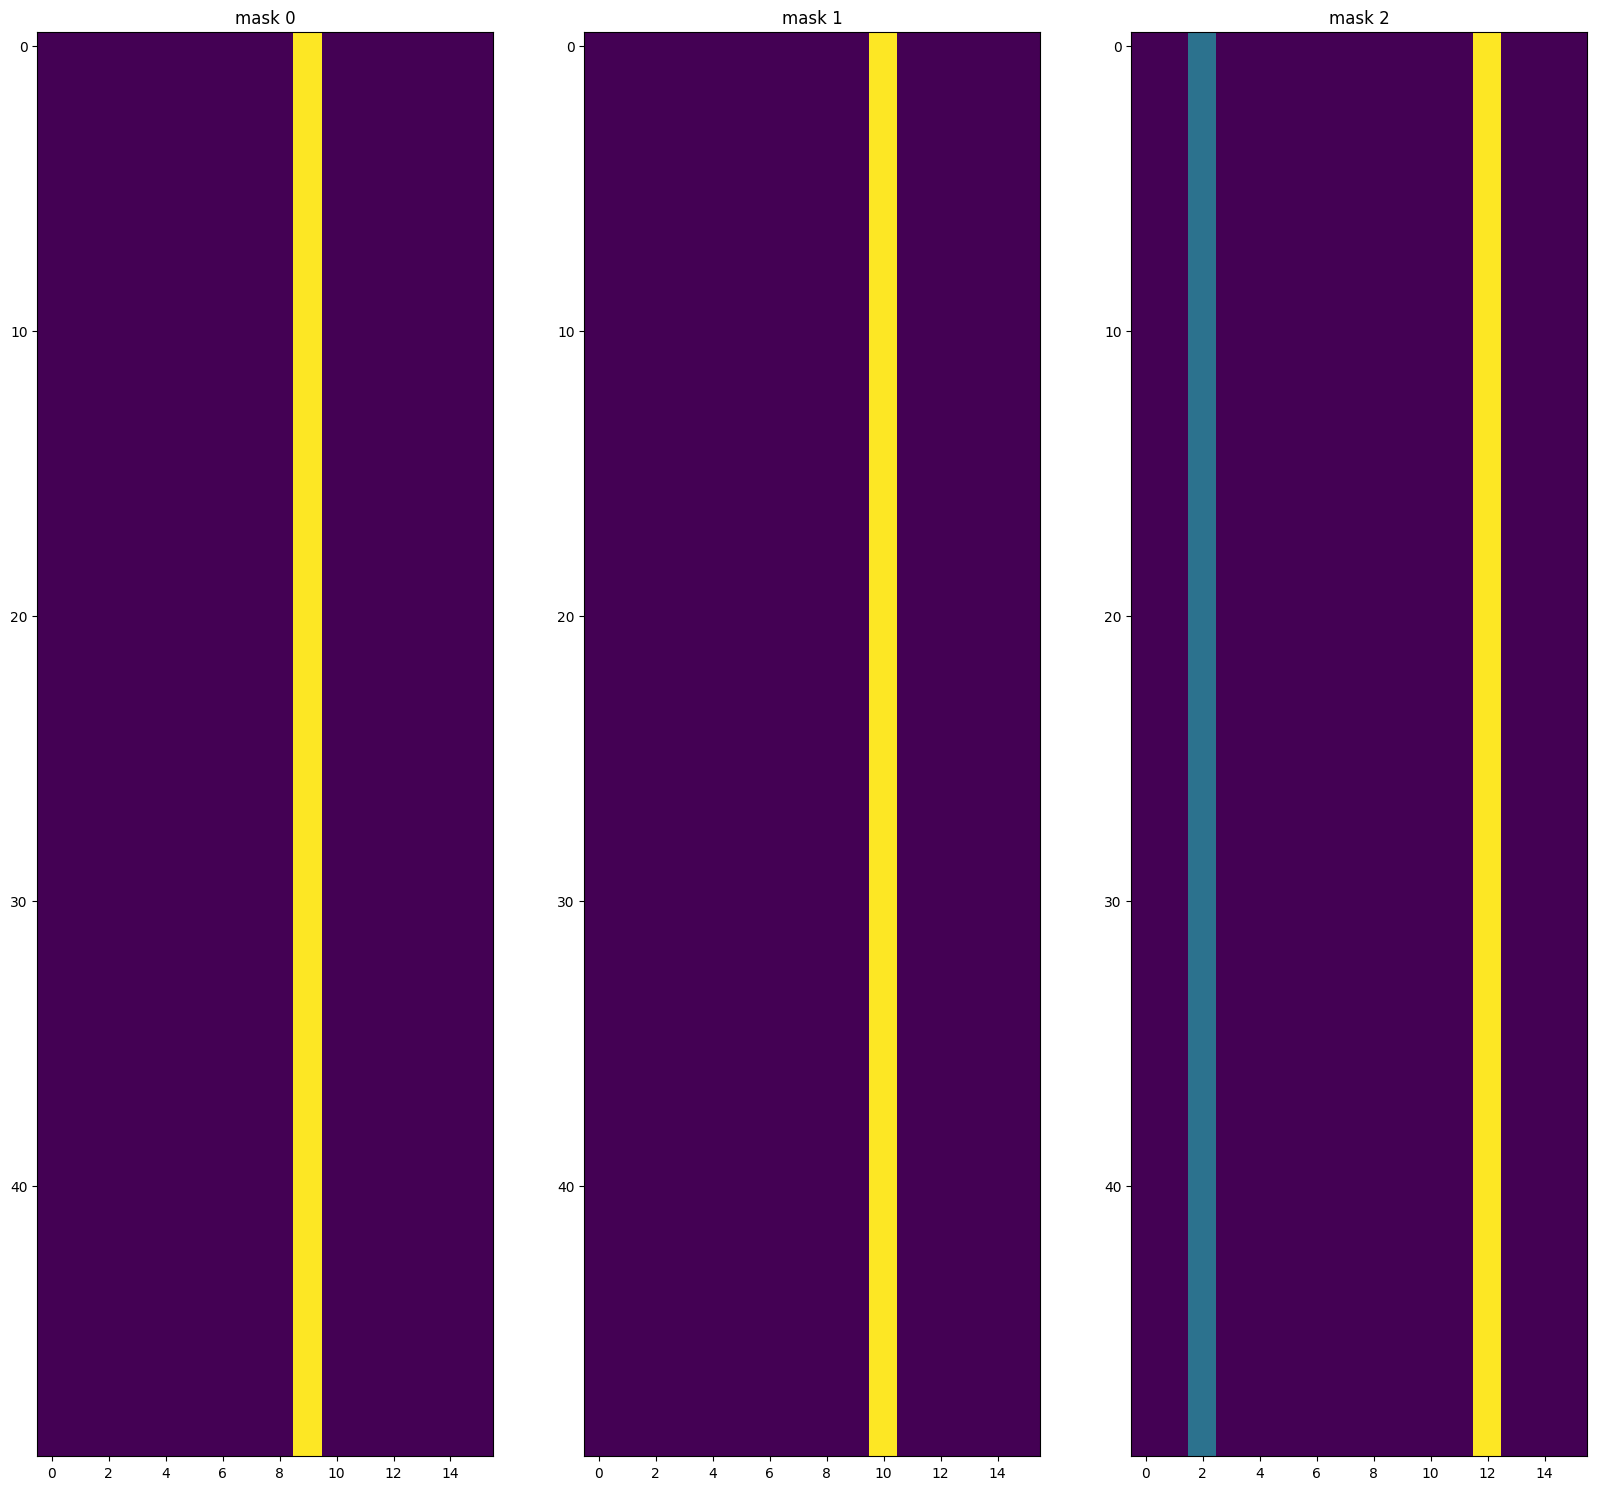

In [ ]:
explain_matrix_plot(model_g, X_g_test)

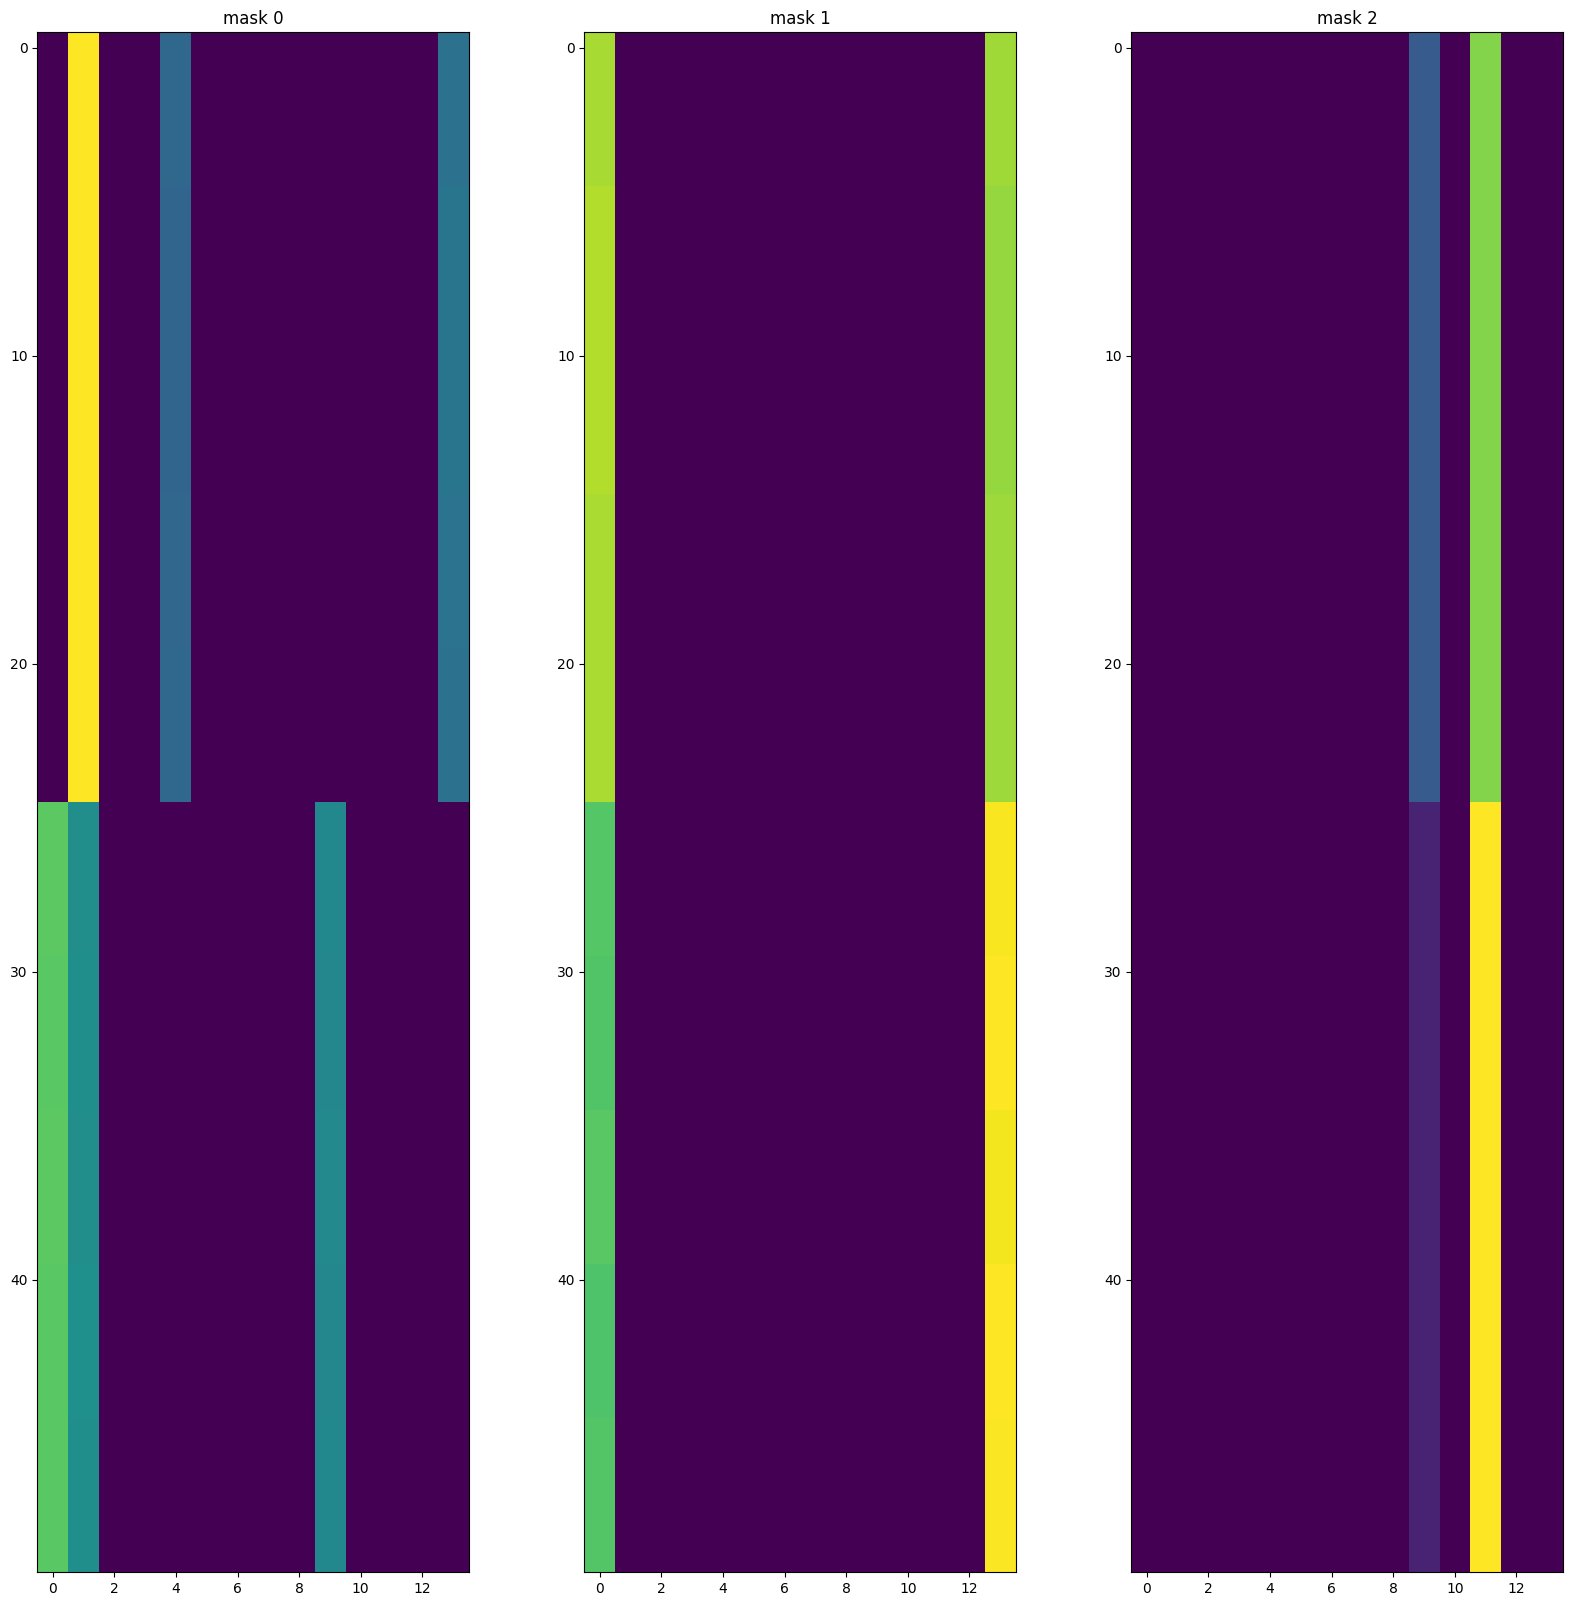

In [ ]:
explain_matrix_plot(model_st, X_st_test)

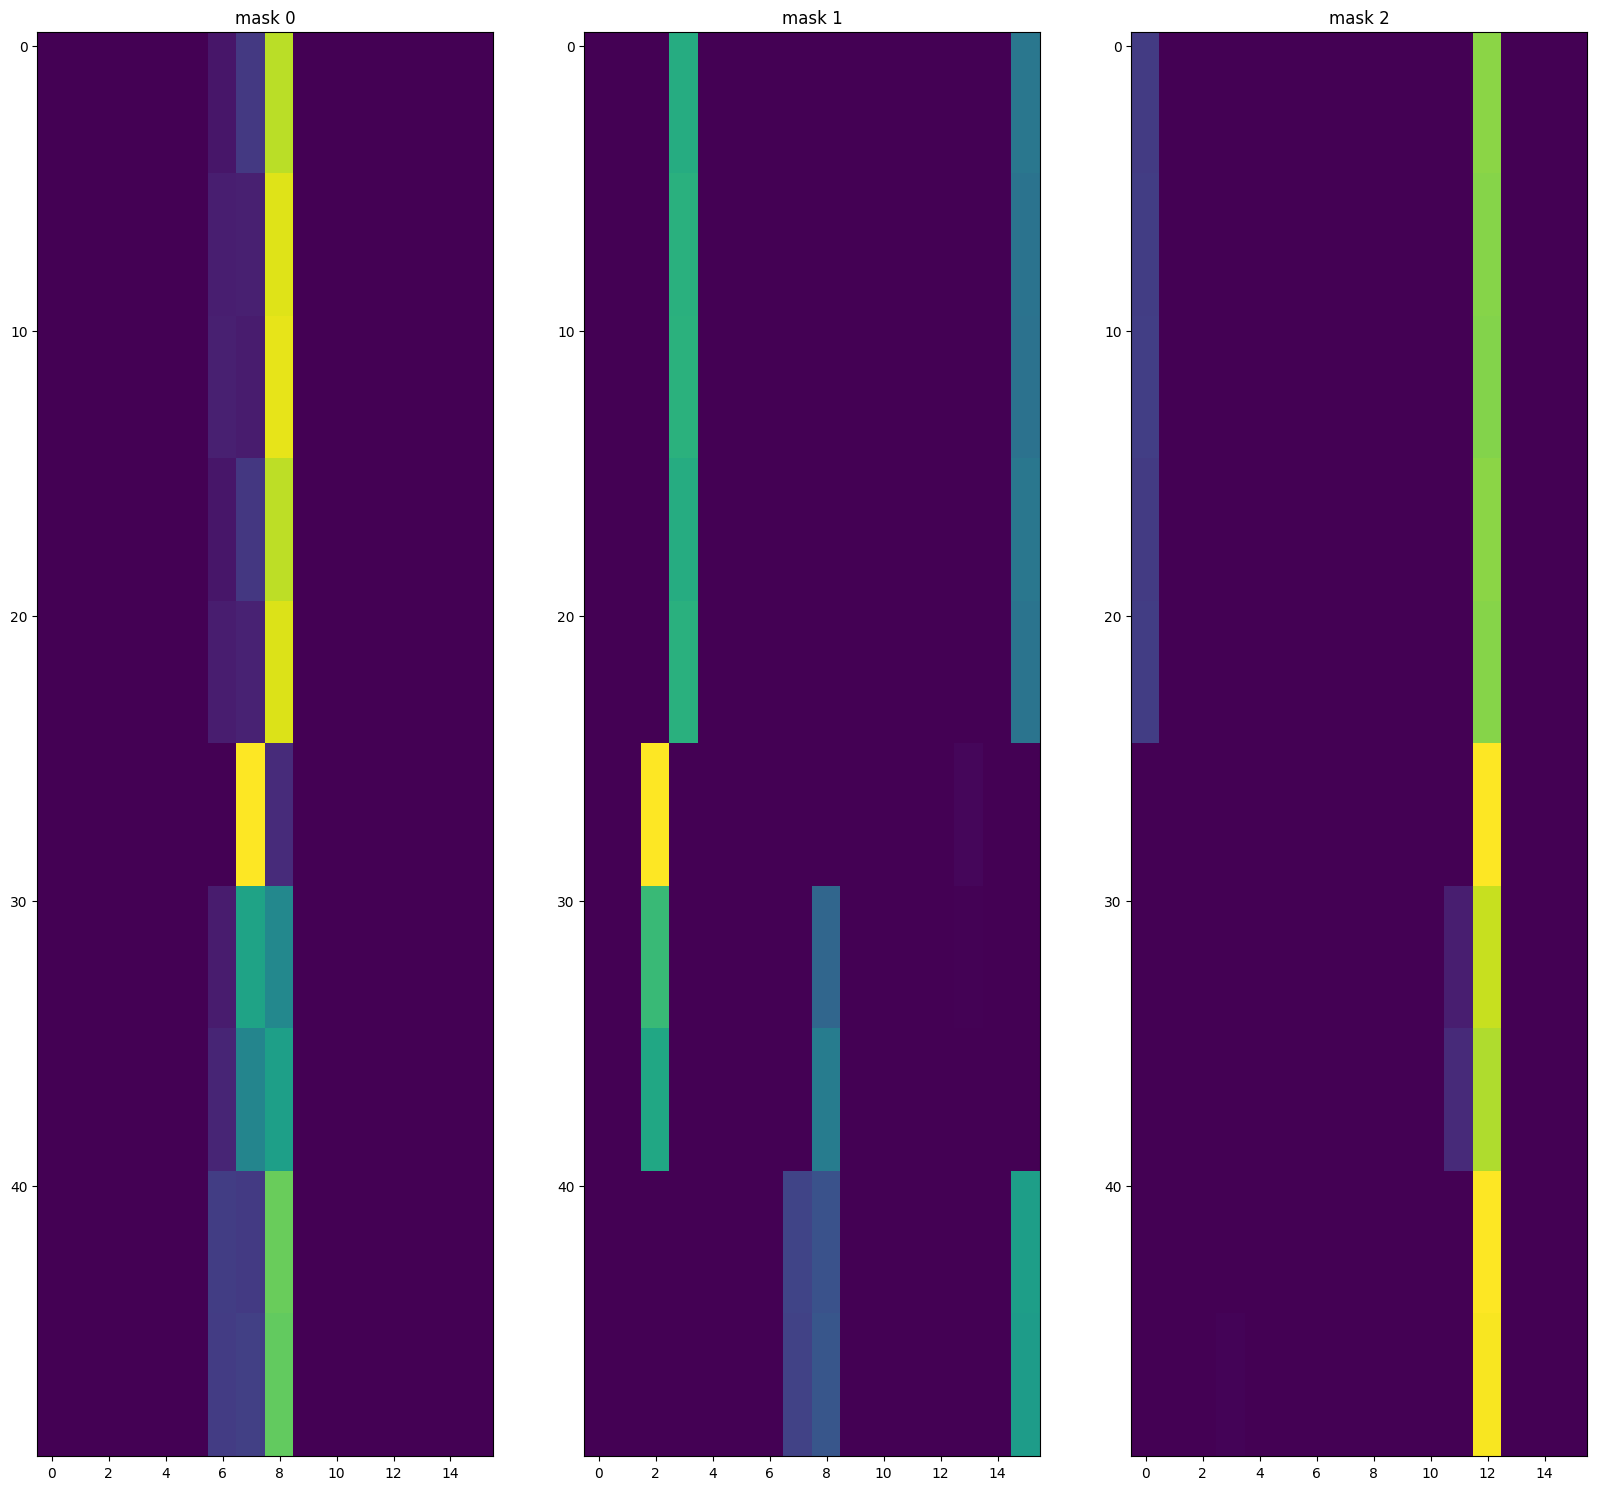

In [ ]:
explain_matrix_plot(model_mm, X_mm_test)